In [ ]:
!pip install uv
!uv pip install -q --system -U --no-progress packaging ninja setuptools wheel
!uv pip install -q --system --no-progress torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121
!uv pip install -q --system --no-progress bitsandbytes datasets accelerate
!uv pip install -q --system --no-progress --no-build-isolation flash-attn
!uv pip install -q --system --no-progress --no-build-isolation git+https://github.com/casper-hansen/AutoAWQ.git
!uv pip install -q --system --no-progress qwen-vl-utils "qwen-vl-utils[decord]==0.0.8"
!uv pip install -q --system --no-progress  sentencepiece attrdict einops pdf2image
!uv pip install -q --system --no-progress git+https://github.com/huggingface/transformers
!apt-get install poppler-utils
!apt-get install fonts-noto-cjk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 34.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (196 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested pac

In [ ]:
import io
import os
import re
import ast
import json
import torch
import pprint
import random
import base64
import warnings
import tempfile
import requests
import numpy as np
import pandas as pd
import polars as pl
from uuid import uuid4
from io import BytesIO
from pathlib import Path
from tqdm import tqdm, trange
from pydantic import BaseModel
from google.colab import drive
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, Tag
from torch.utils.data import DataLoader
from pdf2image import convert_from_path
from dataclasses import asdict, dataclass
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from awq.utils.utils import get_best_device
from qwen_vl_utils import process_vision_info
from typing import List, Optional, Tuple, Union
from IPython.display import Markdown, HTML, display
from PIL import Image, ImageDraw, ImageFont, ImageColor
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, AutoTokenizer

warnings.simplefilter('ignore')

### Set up

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Freelance/NaturAI'
os.chdir(folder_path)

In [ ]:
device = get_best_device()

### Set seed

In [ ]:
seed = 42
random.seed(seed)              # python's built-in random module
np.random.seed(seed)           # numPy
torch.manual_seed(seed)        # pyTorch
torch.cuda.manual_seed(seed)   # for GPU computations in PyTorch
torch.cuda.manual_seed_all(seed)  # if you're using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Init model

In [ ]:
checkpoint = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
model.to(device)

Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger

### Load data

In [ ]:
# prueba = Image.open('Acuerdos/raw/prueba.jpeg')

In [ ]:
temp_dir = tempfile.mkdtemp()
inputs = 'Acuerdos/raw/'
pdf_files = os.listdir(inputs)

for file in tqdm(pdf_files):
    # convert the PDF pages to images
    images = convert_from_path(f'{inputs}{file}', dpi=100, thread_count=6)

    # save each image with a unique name in the temporary directory
    for idx, img in enumerate(images):
        img_filename = f"{os.path.splitext(file)[0]}_page_{idx + 1}.png"
        img.save(os.path.join(temp_dir, img_filename))

print(f'Images saved in temporary folder: {temp_dir}')

100%|██████████| 1/1 [01:16<00:00, 76.22s/it]

Images saved in temporary folder: /tmp/tmpxb5sskgr


In [ ]:
n = 15
dataset = load_dataset('imagefolder', data_dir=temp_dir, split='train')
dataset = dataset.select(range(0,n))

Resolving data files:   0%|          | 0/130 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Cookbook

In [ ]:
def draw_bbox(image, resized_width, resized_height, full_predict):
    original_width = image.width
    original_height = image.height

    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    draw = ImageDraw.Draw(image)

    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())

        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height

        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)

        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized

        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    return image

def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')

    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style

    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

def plot_text_bounding_boxes(img, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    # font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=10)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(ast.literal_eval(bounding_boxes)):
      color = 'green'

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=1
      )

      # Draw the text
      if "text_content" in bounding_box:
        draw.text((abs_x1, abs_y2), bounding_box["text_content"], fill=color, font=font)

    # Display the image
    img.show()

def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def inference(image, prompt, system_prompt="You are a helpful assistant", max_new_tokens=100000):
  image_path = str(image.filename)
  img_url = "file://" + image_path
  system_prompt=f"""
                  You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in
                  QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity.
                """
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width




#### OCR

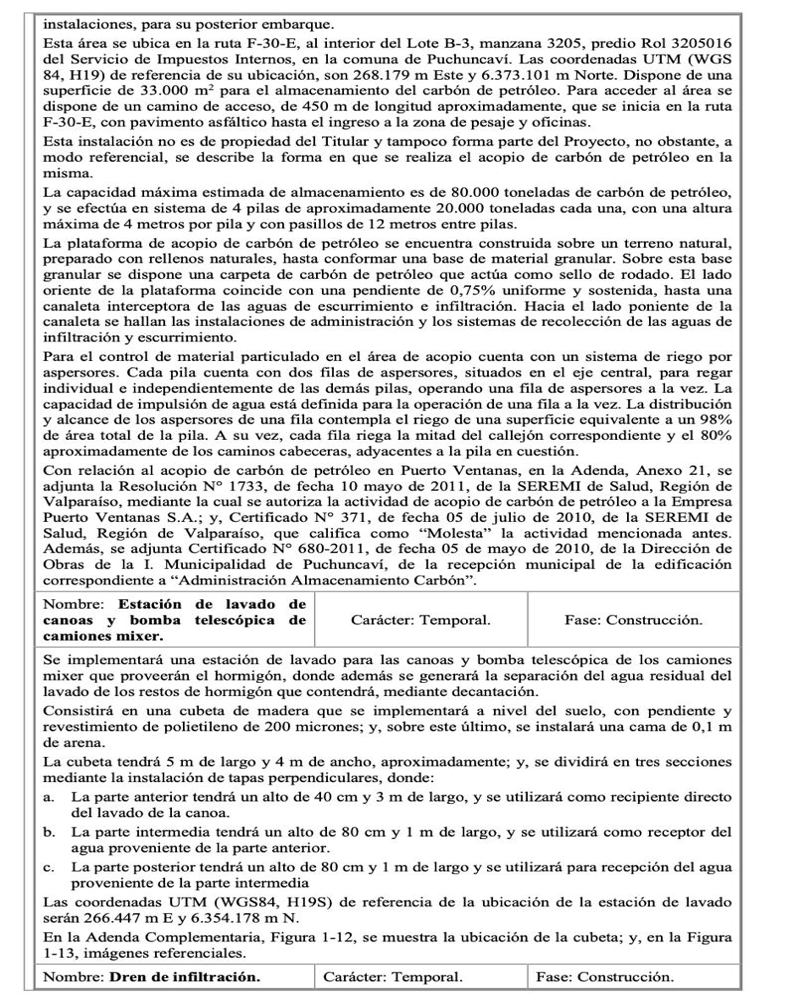

In [ ]:
image = prueba
display(image.resize((800,1000)))

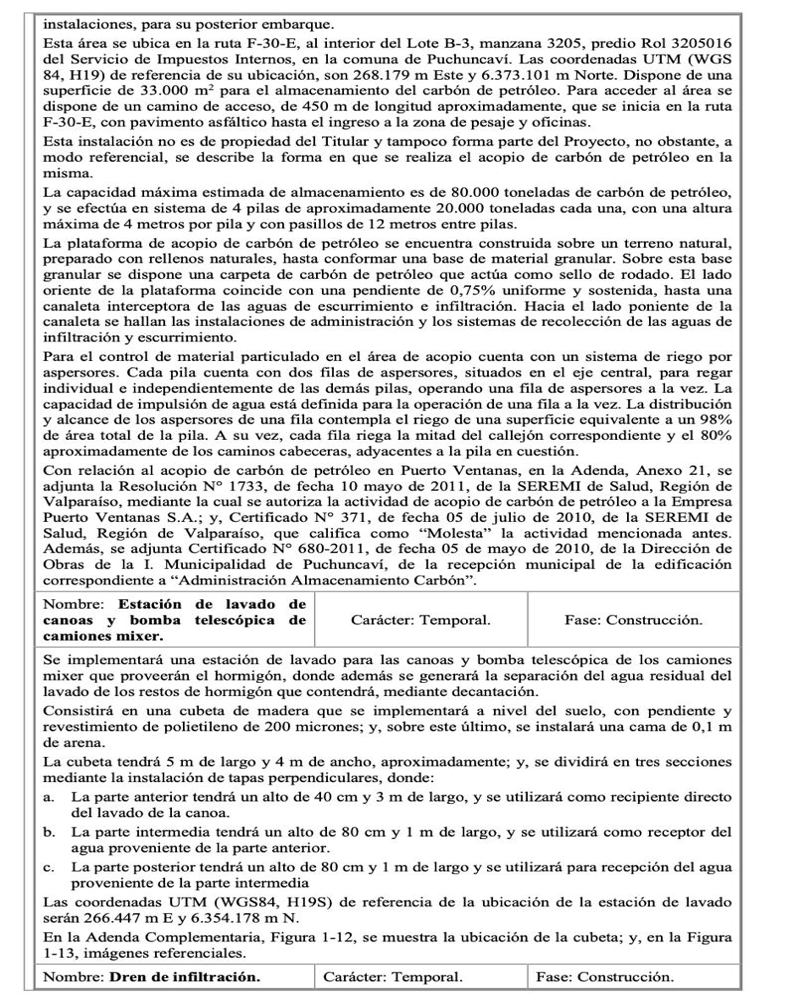

In [ ]:
image = prueba
display(image.resize((800,1000)))

In [ ]:
prompt = "QwenVL HTML, beware of weird table layouts and format them as well as possible."
output, input_height, input_width = inference(image, prompt)

input:
 <|im_start|>system

                  You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in
                  QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity.
                <|im_end|>
<|im_start|>user
QwenVL HTML, beware of weird table layouts and format them as well as possible.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```html
<html><body>
<p>instalaciones, para su posterior embarque.</p> 
 <p>Esta área se ubica en la ruta F-30-E, al interior del Lote B-3, manzana 3205, predio Rol 3205016 del Servicio de Impuestos Internos, en la comuna de Puchuncaví. Las coordenadas UTM (WGS 84, H19) de referencia de su ubicación, son 268.179 m Este y 6.373.101 m Norte. Disponía de una superficie de 33.000 m² para el almacenamiento del carbón de petróleo. Para acceder al área se dispone de un camino

In [ ]:
ordinary_html = clean_and_format_html(output)
display(HTML(ordinary_html))

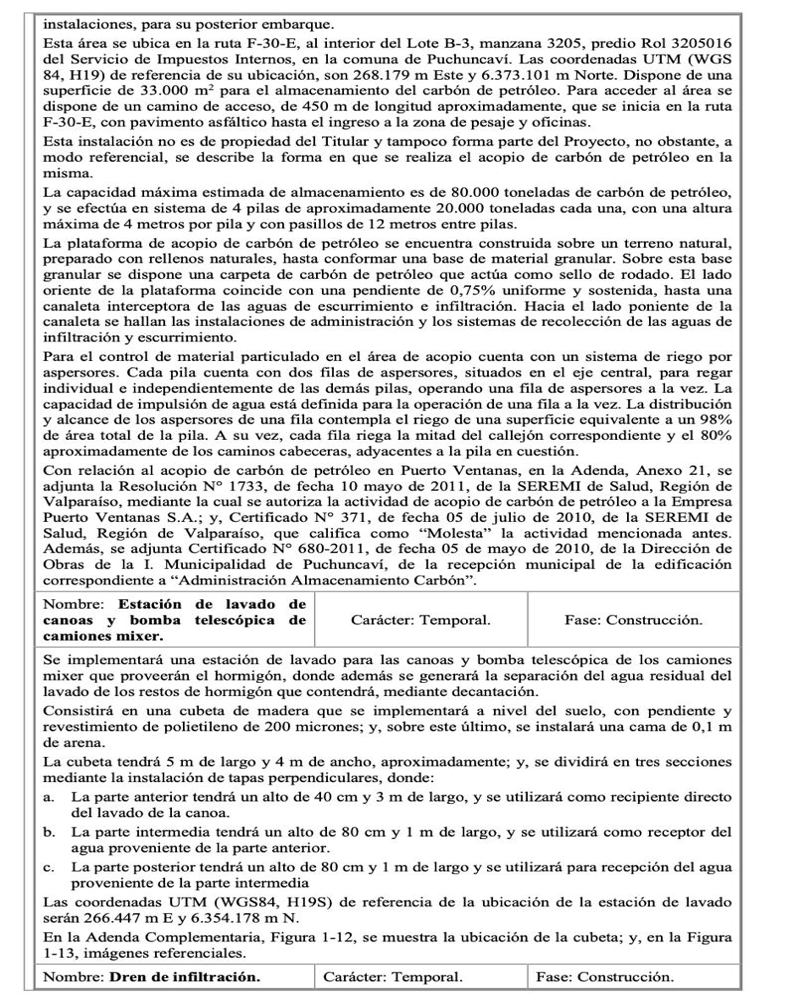

In [ ]:
image = prueba
display(image.resize((800,1000)))

In [ ]:
## Al code

In [ ]:
!pip install uv
!uv pip install -q --system -U --no-progress packaging ninja setuptools wheel
!uv pip install -q --system --no-progress torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121
!uv pip install -q --system --no-progress bitsandbytes datasets accelerate
!uv pip install -q --system --no-progress --no-build-isolation flash-attn
!uv pip install -q --system --no-progress --no-build-isolation git+https://github.com/casper-hansen/AutoAWQ.git
!uv pip install -q --system --no-progress qwen-vl-utils "qwen-vl-utils[decord]==0.0.8"
!uv pip install -q --system --no-progress  sentencepiece attrdict einops pdf2image
!uv pip install -q --system --no-progress git+https://github.com/huggingface/transformers
!apt-get install poppler-utils
!apt-get install fonts-noto-cjk


import io
import os
import re
import ast
import json
import torch
import pprint
import random
import base64
import warnings
import tempfile
import requests
import numpy as np
import pandas as pd
import polars as pl
from uuid import uuid4
from io import BytesIO
from pathlib import Path
from tqdm import tqdm, trange
from pydantic import BaseModel
from google.colab import drive
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, Tag
from torch.utils.data import DataLoader
from pdf2image import convert_from_path
from dataclasses import asdict, dataclass
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from awq.utils.utils import get_best_device
from qwen_vl_utils import process_vision_info
from typing import List, Optional, Tuple, Union
from IPython.display import Markdown, HTML, display
from PIL import Image, ImageDraw, ImageFont, ImageColor
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, AutoTokenizer

warnings.simplefilter('ignore')

seed = 42
random.seed(seed)              # python's built-in random module
np.random.seed(seed)           # numPy
torch.manual_seed(seed)        # pyTorch
torch.cuda.manual_seed(seed)   # for GPU computations in PyTorch
torch.cuda.manual_seed_all(seed)  # if you're using multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


checkpoint = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

model.to(device)


temp_dir = tempfile.mkdtemp()
inputs = 'Acuerdos/raw/'
pdf_files = os.listdir(inputs)

for file in tqdm(pdf_files):
    # convert the PDF pages to images
    images = convert_from_path(f'{inputs}{file}', dpi=100, thread_count=6)

    # save each image with a unique name in the temporary directory
    for idx, img in enumerate(images):
        img_filename = f"{os.path.splitext(file)[0]}_page_{idx + 1}.png"
        img.save(os.path.join(temp_dir, img_filename))

print(f'Images saved in temporary folder: {temp_dir}')


n = 15
dataset = load_dataset('imagefolder', data_dir=temp_dir, split='train')
dataset = dataset.select(range(0,n))

def draw_bbox(image, resized_width, resized_height, full_predict):
    original_width = image.width
    original_height = image.height

    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    draw = ImageDraw.Draw(image)

    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())

        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height

        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)

        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized

        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    return image

def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')

    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style

    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

def plot_text_bounding_boxes(img, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    # font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=10)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(ast.literal_eval(bounding_boxes)):
      color = 'green'

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=1
      )

      # Draw the text
      if "text_content" in bounding_box:
        draw.text((abs_x1, abs_y2), bounding_box["text_content"], fill=color, font=font)

    # Display the image
    img.show()

def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def inference(image, prompt, system_prompt="You are a helpful assistant", max_new_tokens=100000):
  image_path = str(image.filename)
  img_url = "file://" + image_path
  system_prompt=f"""
                  You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in
                  QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity.
                """
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

image = prueba
display(image.resize((800,1000)))

prompt = "QwenVL HTML, beware of weird table layouts and format them as well as possible."
output, input_height, input_width = inference(image, prompt)

ordinary_html = clean_and_format_html(output)
display(HTML(ordinary_html))
